In [1]:
# !pip install opencv-python
# !pip install matplotlib
# !pip install sympy

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import sympy as sp

import os
import math

from ex4_utils import gaussian_prob, kalman_step, sample_gauss

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Assignment 1 - Kalman motion models

## Artifical training data

In [2]:


def generate_sample_path(N:int):
  v = np.linspace(5 * math.pi, 0, N)
  x = np.cos(v) * v
  y = np.sin(v) * v
  return x,y

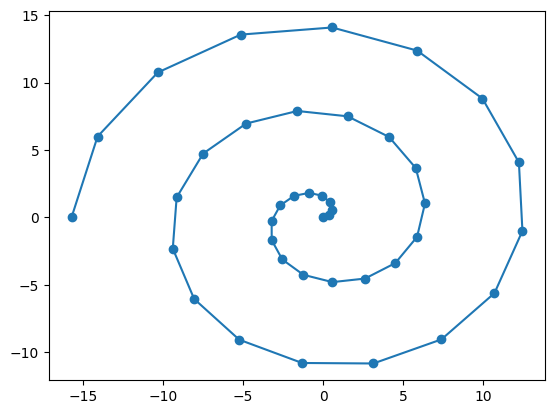

In [3]:
x_sample,y_sample = generate_sample_path(40)
plt.plot(x_sample, y_sample,"-o")
plt.show()

In [4]:
# x = np.array([x_sample, y_sample])
# x.shape

## Motion models

In [5]:
def RandomWalk(r,q):
  # parameters an state
  state_dim = 2
  A = np.array([
      [1,0],
      [0,1],
  ])  # System matrix (on lect. slides: Fi or Φ)
  C =  np.array([
      [1,0],
      [0,1],
  ]) # Observation matrix (on lect. slides: H)
  Q = np.eye(state_dim)*q # System covariance (on lect. slides: Q)
  R = np.eye(state_dim)*r # Observation covariance (on lect. slides: R, …)
  return A, C, Q, R, state_dim

def NCVelocity(q, r):
    state_dim = 4
    
    F = sp.Matrix(np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]]))
    L = sp.Matrix(np.array([[0, 0], [0, 0], [1, 0], [0, 1]]))
    C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    
    T = sp.symbols("T")
    A_exp = sp.exp(F * T)

    Q = sp.integrate((A_exp * L) * q * (A_exp * L).T, (T, 0, T))
    A = A_exp.subs(T, 1)
    A = np.array(A, dtype="float")
    Q = Q.subs(T, 1)
    Q = np.array(Q, dtype="float")

    R = r * np.array([[1, 0], [0, 1]])
    return A, C, Q, R, state_dim

def NCAcceleration(q, r):
    state_dim = 6
    
    F = sp.Matrix(
        np.array(
            [
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
            ]
        )
    )
    L = sp.Matrix(np.array([[0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [0, 1]]))
    C = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
    
    T = sp.symbols("T")
    A_exp = sp.exp(F * T)

    Q = sp.integrate((A_exp * L) * q * (A_exp * L).T, (T, 0, T))
    A = A_exp.subs(T, 1)
    A = np.array(A, dtype="float")
    Q = Q.subs(T, 1)
    Q = np.array(Q, dtype="float")

    R = r * np.array([[1, 0], [0, 1]])
    return A, C, Q, R, state_dim

## Kalman calculation

In [6]:
def kalman_run(x,y, A,C,Q,R):
  # Code from the slides
  sx = np.zeros((x.size, 1), dtype=np.float32).flatten()
  sy = np.zeros((y.size, 1), dtype=np.float32).flatten()
  sx[0] = x[0]
  sy[0] = y[0]
  state = np.zeros((A.shape[0], 1), dtype=np.float32).flatten()
  state[0] = x[0]
  state[1] = y[0]
  covariance = np.eye(A.shape[0], dtype=np.float32)

  for j in range(1, x.size):
      state, covariance, _, _ = kalman_step(
          A,
          C,
          Q,
          R,
          np.reshape(np.array([x[j], y[j]]), (-1, 1)),
          np.reshape(state, (-1, 1)),
          covariance,
      )
      sx[j] = state.squeeze()[0]
      sy[j] = state.squeeze()[1]
  return sx, sy

## output

/tmp/ipykernel_72805/2705624707.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


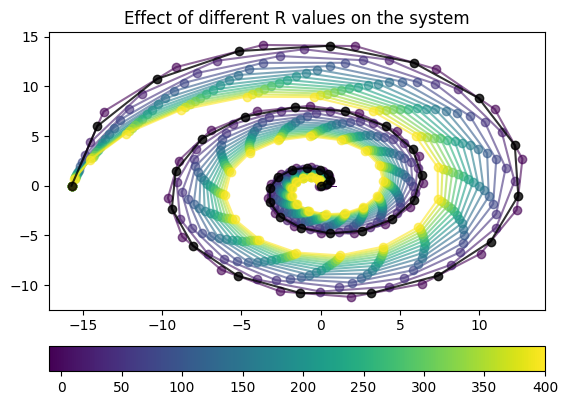

In [7]:
# this code is mostly graphing shenanigans... nothing to do with actual computing of the kalman filter

r_from, r_to = -10, 400
r_values = np.linspace(r_from, r_to,15)
fig, (ax) = plt.subplots(1,1)
gradient = np.linspace(0, 1, 256)[:, None]  # Create a gradient array
gradient_image = plt.imshow(gradient, aspect='auto', extent=[0, 1, -0.1, 0], origin='lower', cmap=plt.cm.viridis, alpha=1,norm=mpl.colors.Normalize(vmin=r_from, vmax=r_to))


colors = plt.cm.viridis(np.linspace(0, 1, len(r_values)))  # Gradient from blue to yellow
for r, color in zip(r_values, colors):
  A, C, Q, R, state_dim = RandomWalk(r,50)
  sx, sy = kalman_run(x_sample,y_sample, A, C, Q, R)
  ax.plot(sx,sy,"-o", alpha=0.6, label=f"r:{r}", c=color)

ax.plot(x_sample, y_sample,"-o", alpha=0.8, c="black")

# gradient_patches = [mpatches.Patch(color=color, label=f'{round(r_values[i],2)}') for i, color in enumerate(colors)]
# plt.legend(handles=gradient_patches, loc='lower right', edgecolor='black', framealpha=1)

fig.colorbar(gradient_image, ax=ax, orientation='horizontal', pad=0.1)

ax.set_title("Effect of different R values on the system")
fig.savefig("r_values.png")
fig.show()

/tmp/ipykernel_72805/2836918363.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


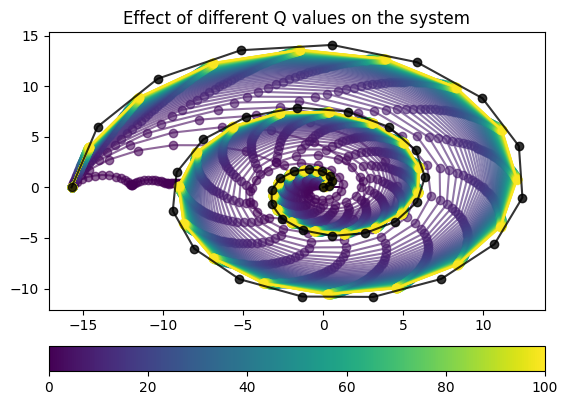

In [8]:
q_from, q_to = 0, 100
q_values = np.linspace(q_from, q_to, 100)
fig, (ax) = plt.subplots(1,1)


# colorbar
gradient = np.linspace(0, 1, 256)[:, None]  # Create a gradient array
gradient_image = plt.imshow(gradient, aspect='auto', extent=[0, 1, -0.1, 0], origin='lower', cmap=plt.cm.viridis, alpha=1,norm=mpl.colors.Normalize(vmin=q_from, vmax=q_to))
colors = plt.cm.viridis(np.linspace(0, 1, len(q_values)))  # Gradient from blue to yellow
fig.colorbar(gradient_image, ax=ax, orientation='horizontal', pad=0.1)

# paths
for q, color in zip(q_values, colors):
  A, C, Q, R, state_dim = RandomWalk(50,q)
  sx, sy = kalman_run(x_sample,y_sample, A, C, Q, R)
  ax.plot(sx,sy,"-o", alpha=0.6, label=f"q:{q}", c=color)

# originl path
ax.plot(x_sample, y_sample,"-o", alpha=0.8, c="black")

ax.set_title("Effect of different Q values on the system")
fig.savefig("q_values.png")
fig.show()

In [9]:
def label_grid(axes,rows,cols):
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)

  for ax, row in zip(axes[:,0], rows):
      ax.set_ylabel(row, rotation=0, size='large')

In [10]:
systems = [RandomWalk, NCVelocity, NCAcceleration]
q_values = np.linspace(1,100, 3)
r_values = np.linspace(1,100, 3)

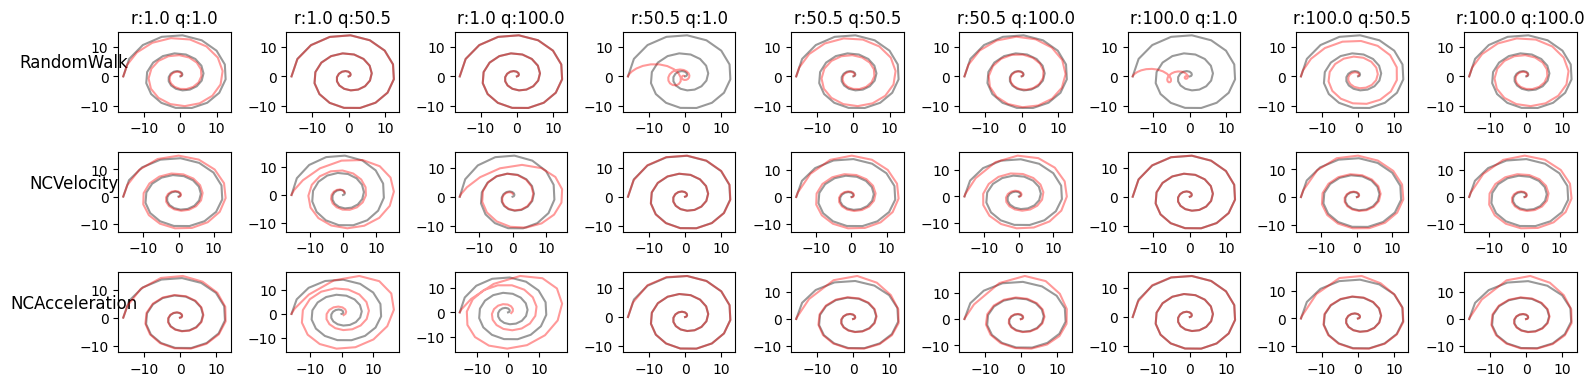

In [11]:
cols = len(q_values) * len(r_values)
fig, ax = plt.subplots(len(systems), cols, figsize=(16,4))
col = 0
row = 0
row_names = []
color_names = []
for sys in systems:
  color_names.append(sys.__name__)
  for r in r_values:
    for q in q_values:
      row_names.append(f"r:{r} q:{q}")
      axis = ax[row][col%cols]
      A, C, Q, R, state_dim = sys(r,q)
      sx, sy = kalman_run(x_sample,y_sample, A, C, Q, R)
      axis.plot(x_sample,y_sample,"-", alpha=0.4, c="black")
      axis.plot(sx,sy,"-", alpha=0.4, c="red")
      axis.set
      col += 1
  row += 1

label_grid(ax, color_names, row_names)
plt.tight_layout(pad=1.2)
plt.show()

# Tracker

Using the implemeted code here, to construct a particle based tracker

In [12]:
from ex2_utils import Tracker, create_epanechnik_kernel, get_patch, extract_histogram

**VOT** tracker utils

In [19]:
import time
import cv2
from sequence_utils import VOTSequence


def track(tracker, sequence="car", renderPoints = False):
  # set the path to directory where you have the sequences
  dataset_path = "data"

  # visualization and setup parameters
  win_name = "Tracking window"
  reinitialize = True
  show_gt = False
  video_delay = 15
  font = cv2.FONT_HERSHEY_PLAIN

  # create sequence object
  sequence = VOTSequence(dataset_path, sequence)
  init_frame = 0
  n_failures = 0

  time_all = 0

  # initialize visualization window
  sequence.initialize_window(win_name)
  # tracking loop - goes over all frames in the video sequence
  frame_idx = 0
  while frame_idx < sequence.length():
    img = cv2.imread(sequence.frame(frame_idx))
    # initialize or track
    if frame_idx == init_frame:
        # initialize tracker (at the beginning of the sequence or after tracking failure)
        t_ = time.time()
        tracker.initialize(img, sequence.get_annotation(frame_idx, type="rectangle"))
        time_all += time.time() - t_
        predicted_bbox = sequence.get_annotation(frame_idx, type="rectangle")
    else:
        # track on current frame - predict bounding box
        t_ = time.time()
        predicted_bbox = tracker.track(img)
        time_all += time.time() - t_

    # calculate overlap (needed to determine failure of a tracker)
    gt_bb = sequence.get_annotation(frame_idx, type="rectangle")
    o = sequence.overlap(predicted_bbox, gt_bb)

    # draw ground-truth and predicted bounding boxes, frame numbers and show image

    if ("get_particles" in dir(tracker) and renderPoints):
       particles = tracker.get_particles()
       sequence.draw_particles(img, particles)

    if show_gt:
        sequence.draw_region(img, gt_bb, (0, 255, 0), 1)
    sequence.draw_region(img, predicted_bbox, (0, 0, 255), 2)
    sequence.draw_text(img, "%d/%d" % (frame_idx + 1, sequence.length()), (25, 25))
    sequence.draw_text(img, "Fails: %d" % n_failures, (25, 55))
    sequence.show_image(img, video_delay)

    if o > 0 or not reinitialize:
        # increase frame counter by 1
        frame_idx += 1
    else:
        # increase frame counter by 5 and set re-initialization to the next frame
        frame_idx += 5
        init_frame = frame_idx
        n_failures += 1

  print("Tracking speed: %.1f FPS" % (sequence.length() / time_all))
  print("Tracker failed %d times" % n_failures)
  cv2.destroyAllWindows()
  return n_failures, (sequence.length() / time_all)

In [35]:
NBINS = 9
ALPHA = 0.05

SIGMA = 1
Q = 5
R = 1
N_PARTICLES = 100

class ParticleTracker(Tracker):
 
    def __init__(self, system):
        super().__init__({})
        self.system = system # NCV, RW, ...

    def initialize(self, image, region):
        if len(region) == 8:
            x_ = np.array(region[::2])
            y_ = np.array(region[1::2])
            region = [np.min(x_), np.min(y_), np.max(x_) - np.min(x_) + 1,
                      np.max(y_) - np.min(y_) + 1]

        self.position = (region[0] + region[2] / 2, region[1] + region[3] / 2)
        

        # Get histogram using epanechnikov - copy paste from previous homeworks
        self.kernel = create_epanechnik_kernel(region[2], region[3], 1)
        self.size = (self.kernel.shape[1], self.kernel.shape[0])
        patch, _ = get_patch(image, self.position, self.size)
        self.q = extract_histogram(patch, NBINS, self.kernel)

        # Frame 1
        self.A, self.C, self.Q_i, self.R_i, self.num_params = self.system(Q, R)

        # x y vx vy
        # self.particle_state = np.array([self.position[0], self.position[1]])
        self.particle_state = [self.position[0], self.position[1], 0, 0]
        # self.particle_state = [self.position[0], self.position[1], 0, 0, 0, 0]
        self.particles = sample_gauss(self.particle_state, self.Q_i, N_PARTICLES)
        self.weights = np.ones(N_PARTICLES)
    
    def get_particles(self):
        return self.particles.copy()[:,:2]

    def track(self, image):
        # Sample new particles
        weights_norm = self.weights / np.sum(self.weights)
        weights_cumsumed = np.sum(weights_norm)
        rand_samples = np.random.rand(N_PARTICLES, 1)
        sampled_idxs = np.digitize(rand_samples, weights_cumsumed)
        particles_new = self.particles[sampled_idxs.flatten(), :]

        # Apply dynamic model to particles
        noise_mean = np.zeros(self.A.shape[0])
        noise = sample_gauss(noise_mean, self.Q_i, N_PARTICLES)
        self.particles = np.dot(self.A, particles_new.T).T + noise

        # Update particle weights
        for i, particle in enumerate(self.particles):
            patch, _ = get_patch(image, (particle[0], particle[1]), self.size)
            q = extract_histogram(patch, NBINS, self.kernel)
            distance = (np.linalg.norm(np.sqrt(q) - np.sqrt(self.q))) / np.sqrt(2)
            sigma = 1
            self.weights[i] = np.exp(-0.5 * (distance / sigma) ** 2)

        # New state
        weights_norm = self.weights / np.sum(self.weights)
        normed = self.particles * np.kron(weights_norm, np.ones((self.num_params,1))).T 
        self.position = (np.sum(normed[0]), np.sum(normed[1]))

        patch, _ = get_patch(image, self.position, self.size)
        q_new = extract_histogram(patch, NBINS, self.kernel)
        self.q = ((1 - ALPHA) * self.q + ALPHA * q_new)

        return [self.position[0] - (self.size[0] / 2),
                self.position[1] - (self.size[1] / 2), self.size[0],
                self.size[1]]



In [36]:
t = ParticleTracker(NCVelocity)
track(t, "bolt", renderPoints=True)

Tracking speed: 60.8 FPS
Tracker failed 59 times


(59, 60.771480648031456)